# Ejercicio 10 
## Pipeline de Clasificación: Heart Disease UCI


**Dataset:** Heart Disease - UCI Machine Learning Repository

**Fuente:** https://archive.ics.uci.edu/dataset/45/heart+disease

**Objetivo:** Predecir la presencia de enfermedad cardíaca en pacientes basándose en 13 atributos clínicos.

**Modelos a comparar:**
1. Support Vector Machine (SVM)
2. Random Forest
3. Gradient Boosting
4. Multi-Layer Perceptron (MLP)

## 1. Configuración del Entorno 

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)


## 2. Carga y Exploración del Dataset

### Descripción del Dataset Heart Disease

Este dataset contiene 303 registros de pacientes con 14 atributos (13 features + 1 target). 

**Atributos:**
- `age`: Edad del paciente
- `sex`: Sexo (1=masculino, 0=femenino)
- `cp`: Tipo de dolor de pecho (0-3)
- `trestbps`: Presión arterial en reposo (mm Hg)
- `chol`: Colesterol sérico (mg/dl)
- `fbs`: Azúcar en sangre en ayunas > 120 mg/dl (1=verdadero, 0=falso)
- `restecg`: Resultados electrocardiográficos en reposo (0-2)
- `thalach`: Frecuencia cardíaca máxima alcanzada
- `exang`: Angina inducida por ejercicio (1=sí, 0=no)
- `oldpeak`: Depresión ST inducida por ejercicio
- `slope`: Pendiente del segmento ST de ejercicio pico
- `ca`: Número de vasos principales coloreados por fluoroscopia (0-3)
- `thal`: Talasemia (3=normal, 6=defecto fijo, 7=defecto reversible)
- `target`: Diagnóstico de enfermedad cardíaca (1=enfermo, 0=sano)

In [28]:
# Cargar el dataset
data = pd.read_csv('heart.csv')
print("Dataset cargado desde: heart.csv")

print(f"\nDimensiones del dataset: {data.shape}")
print(f"Filas: {data.shape[0]}, Columnas: {data.shape[1]}")

Dataset cargado desde: heart.csv

Dimensiones del dataset: (303, 14)
Filas: 303, Columnas: 14


In [29]:
print("Primeras 5 filas del dataset:")
data.head()

Primeras 5 filas del dataset:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [30]:
print("Información del dataset:")
data.info()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [31]:
print("Estadísticas descriptivas:")
data.describe()

Estadísticas descriptivas:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [32]:
print("Valores nulos por columna:")
print(data.isnull().sum())
print(f"\nTotal de valores nulos: {data.isnull().sum().sum()}")

Valores nulos por columna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Total de valores nulos: 0


In [33]:
print("Distribución de la variable objetivo (target):")
print(data['target'].value_counts())
print(f"\nPorcentaje de casos positivos: {data['target'].mean()*100:.2f}%")

Distribución de la variable objetivo (target):
target
1    165
0    138
Name: count, dtype: int64

Porcentaje de casos positivos: 54.46%


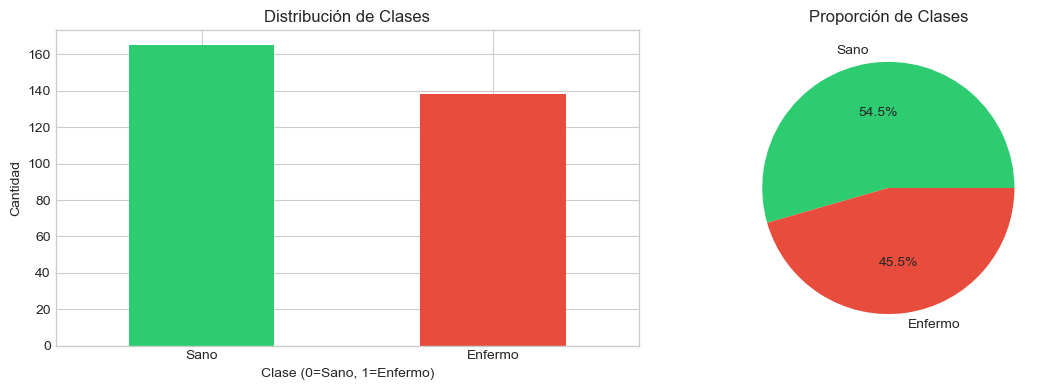

In [34]:
# Visualización de la distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
colors = ['#2ecc71', '#e74c3c']  # Verde para sano, rojo para enfermo
ax1 = axes[0]
data['target'].value_counts().plot(kind='bar', ax=ax1, color=colors)
ax1.set_title('Distribución de Clases')
ax1.set_xlabel('Clase (0=Sano, 1=Enfermo)')
ax1.set_ylabel('Cantidad')
ax1.set_xticklabels(['Sano', 'Enfermo'], rotation=0)

# Gráfico de torta
ax2 = axes[1]
data['target'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                                    colors=colors, labels=['Sano', 'Enfermo'])
ax2.set_title('Proporción de Clases')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('distribucion_clases.png', dpi=150, bbox_inches='tight')
plt.show()

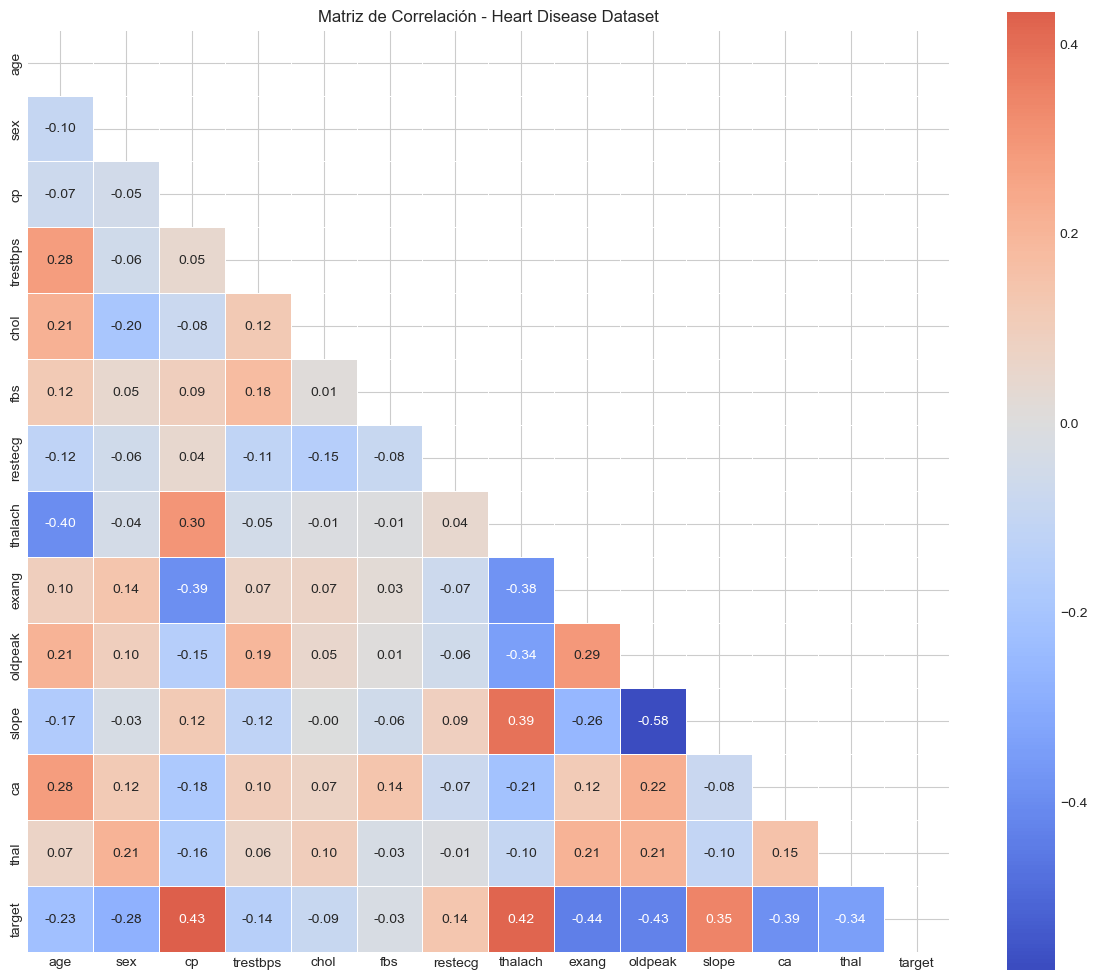

In [35]:
# Matriz de correlación
fig, ax = plt.subplots(figsize=(12, 10))

corr_matrix = data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, square=True, linewidths=0.5)
ax.set_title('Matriz de Correlación - Heart Disease Dataset')
plt.tight_layout()
plt.savefig('matriz_correlacion.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Preprocesamiento de Datos

- División train/test (80/20) con estratificación
- El escalado se hará dentro de cada pipeline para evitar data leakage

In [36]:
X = data.drop('target', axis=1)
y = data['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nColumnas de features: {list(X.columns)}")

Features shape: (303, 13)
Target shape: (303,)

Columnas de features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [37]:
# División del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Mantiene la proporción de clases
)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")
print(f"\nDistribución en train:\n{y_train.value_counts()}")
print(f"\nDistribución en test:\n{y_test.value_counts()}")

Tamaño del conjunto de entrenamiento: 242
Tamaño del conjunto de prueba: 61

Distribución en train:
target
1    132
0    110
Name: count, dtype: int64

Distribución en test:
target
1    33
0    28
Name: count, dtype: int64


## 4. Pipelines y Espacios de Hiperparámetros

In [38]:
# validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Validación cruzada configurada: 5-Fold Stratified")

Validación cruzada configurada: 5-Fold Stratified


### 4.1 Support Vector Machine (SVM)

In [39]:
# Pipeline SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),  # SVM es sensible a la escala
    ('svm', SVC(random_state=42, probability=True))  # probability=True para ROC-AUC
])

# Espacio de hiperparámetros
param_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1],
    'svm__kernel': ['rbf', 'linear', 'poly']
}

n_combinaciones_svm = len(param_svm['svm__C']) * len(param_svm['svm__gamma']) * len(param_svm['svm__kernel'])
print(f"Combinaciones a evaluar: {n_combinaciones_svm}")

Combinaciones a evaluar: 48


In [40]:
# Entrenamiento SVM con GridSearchCV

t0 = time()
grid_svm = GridSearchCV(
    pipe_svm,
    param_svm,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,  # Usar todos los cores disponibles
    verbose=1
)

grid_svm.fit(X_train, y_train)
tiempo_svm = time() - t0

print(f"Mejores parámetros: {grid_svm.best_params_}")
print(f"Mejor accuracy (CV): {grid_svm.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Mejor accuracy (CV): 0.8178


### 4.2 Random Forest

In [41]:
# Pipeline Random Forest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),  # RF no lo necesita pero mantenemos consistencia
    ('rf', RandomForestClassifier(random_state=42))
])

# Espacio de hiperparámetros
param_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

n_combinaciones_rf = 3 * 4 * 3 * 3
print(f"Combinaciones totales: {n_combinaciones_rf}")
print("Usaremos RandomizedSearchCV con 50 iteraciones para acelerar")

Combinaciones totales: 108
Usaremos RandomizedSearchCV con 50 iteraciones para acelerar


In [42]:
# Entrenamiento Random Forest con RandomizedSearchCV

t0 = time()
grid_rf = RandomizedSearchCV(
    pipe_rf,
    param_rf,
    n_iter=50,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

grid_rf.fit(X_train, y_train)
tiempo_rf = time() - t0

print(f"Mejores parámetros: {grid_rf.best_params_}")
print(f"Mejor accuracy (CV): {grid_rf.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 30}
Mejor accuracy (CV): 0.8304


### 4.3 Gradient Boosting

In [43]:
# Pipeline Gradient Boosting
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Espacio de hiperparámetros
param_gb = {
    'gb__n_estimators': [50, 100, 200],
    'gb__learning_rate': [0.01, 0.1, 0.2],
    'gb__max_depth': [3, 5, 7],
    'gb__subsample': [0.8, 1.0]
}

n_combinaciones_gb = 3 * 3 * 3 * 2
print(f"Combinaciones a evaluar: {n_combinaciones_gb}")

Combinaciones a evaluar: 54


In [44]:
# Entrenamiento Gradient Boosting con GridSearchCV

t0 = time()
grid_gb = GridSearchCV(
    pipe_gb,
    param_gb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_gb.fit(X_train, y_train)
tiempo_gb = time() - t0

print(f"Mejores parámetros: {grid_gb.best_params_}")
print(f"Mejor accuracy (CV): {grid_gb.best_score_:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros: {'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__n_estimators': 50, 'gb__subsample': 0.8}
Mejor accuracy (CV): 0.8017


### 4.4 Multi-Layer Perceptron (MLP)

In [45]:
# Pipeline MLP
pipe_mlp = Pipeline([
    ('scaler', StandardScaler()),  # Crítico para redes neuronales
    ('mlp', MLPClassifier(random_state=42, max_iter=1000, early_stopping=True))
])

# Espacio de hiperparámetros
param_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01]
}

n_combinaciones_mlp = 5 * 2 * 3 * 2
print(f"Combinaciones totales: {n_combinaciones_mlp}")
print("Usaremos RandomizedSearchCV con 40 iteraciones")

Combinaciones totales: 60
Usaremos RandomizedSearchCV con 40 iteraciones


In [46]:
# Entrenamiento MLP con RandomizedSearchCV

t0 = time()
grid_mlp = RandomizedSearchCV(
    pipe_mlp,
    param_mlp,
    n_iter=40,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

grid_mlp.fit(X_train, y_train)
tiempo_mlp = time() - t0

print(f"Mejores parámetros: {grid_mlp.best_params_}")
print(f"Mejor accuracy (CV): {grid_mlp.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores parámetros: {'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__alpha': 0.001, 'mlp__activation': 'tanh'}
Mejor accuracy (CV): 0.8304


## 5. Comparación de Modelos

In [47]:
# Función para evaluar modelos
def evaluar_modelo(nombre, grid, X_test, y_test):
    """Evalúa un modelo y retorna diccionario con métricas."""
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
    
    return {
        'Modelo': nombre,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'CV_Score': grid.best_score_,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

In [48]:
# Evaluar todos los modelos
modelos = {
    'SVM': grid_svm,
    'Random Forest': grid_rf,
    'Gradient Boosting': grid_gb,
    'MLP': grid_mlp
}

resultados_lista = []
for nombre, grid in modelos.items():
    resultado = evaluar_modelo(nombre, grid, X_test, y_test)
    resultados_lista.append(resultado)
    print(f"\n{'='*50}")
    print(f"{nombre}")
    print(f"{'='*50}")
    print(f"Accuracy:  {resultado['Accuracy']:.4f}")
    print(f"Precision: {resultado['Precision']:.4f}")
    print(f"Recall:    {resultado['Recall']:.4f}")
    print(f"F1-Score:  {resultado['F1-Score']:.4f}")
    print(f"ROC-AUC:   {resultado['ROC-AUC']:.4f}")


SVM
Accuracy:  0.8197
Precision: 0.7619
Recall:    0.9697
F1-Score:  0.8533
ROC-AUC:   0.8766

Random Forest
Accuracy:  0.8361
Precision: 0.7805
Recall:    0.9697
F1-Score:  0.8649
ROC-AUC:   0.9102

Gradient Boosting
Accuracy:  0.8033
Precision: 0.7692
Recall:    0.9091
F1-Score:  0.8333
ROC-AUC:   0.8712

MLP
Accuracy:  0.8033
Precision: 0.7692
Recall:    0.9091
F1-Score:  0.8333
ROC-AUC:   0.8983


In [49]:
# Crear DataFrame con resultados
df_resultados = pd.DataFrame(resultados_lista)
df_display = df_resultados[['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'CV_Score']]

print("TABLA COMPARATIVA DE RESULTADOS - CLASIFICACIÓN")
print(df_display.to_string(index=False))

# Guardar resultados
df_display.to_csv('resultados_clasificacion.csv', index=False)
print("\nResultados guardados en: resultados_clasificacion.csv")

TABLA COMPARATIVA DE RESULTADOS - CLASIFICACIÓN
           Modelo  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV_Score
              SVM  0.819672   0.761905 0.969697  0.853333 0.876623  0.817772
    Random Forest  0.836066   0.780488 0.969697  0.864865 0.910173  0.830442
Gradient Boosting  0.803279   0.769231 0.909091  0.833333 0.871212  0.801701
              MLP  0.803279   0.769231 0.909091  0.833333 0.898268  0.830357

Resultados guardados en: resultados_clasificacion.csv


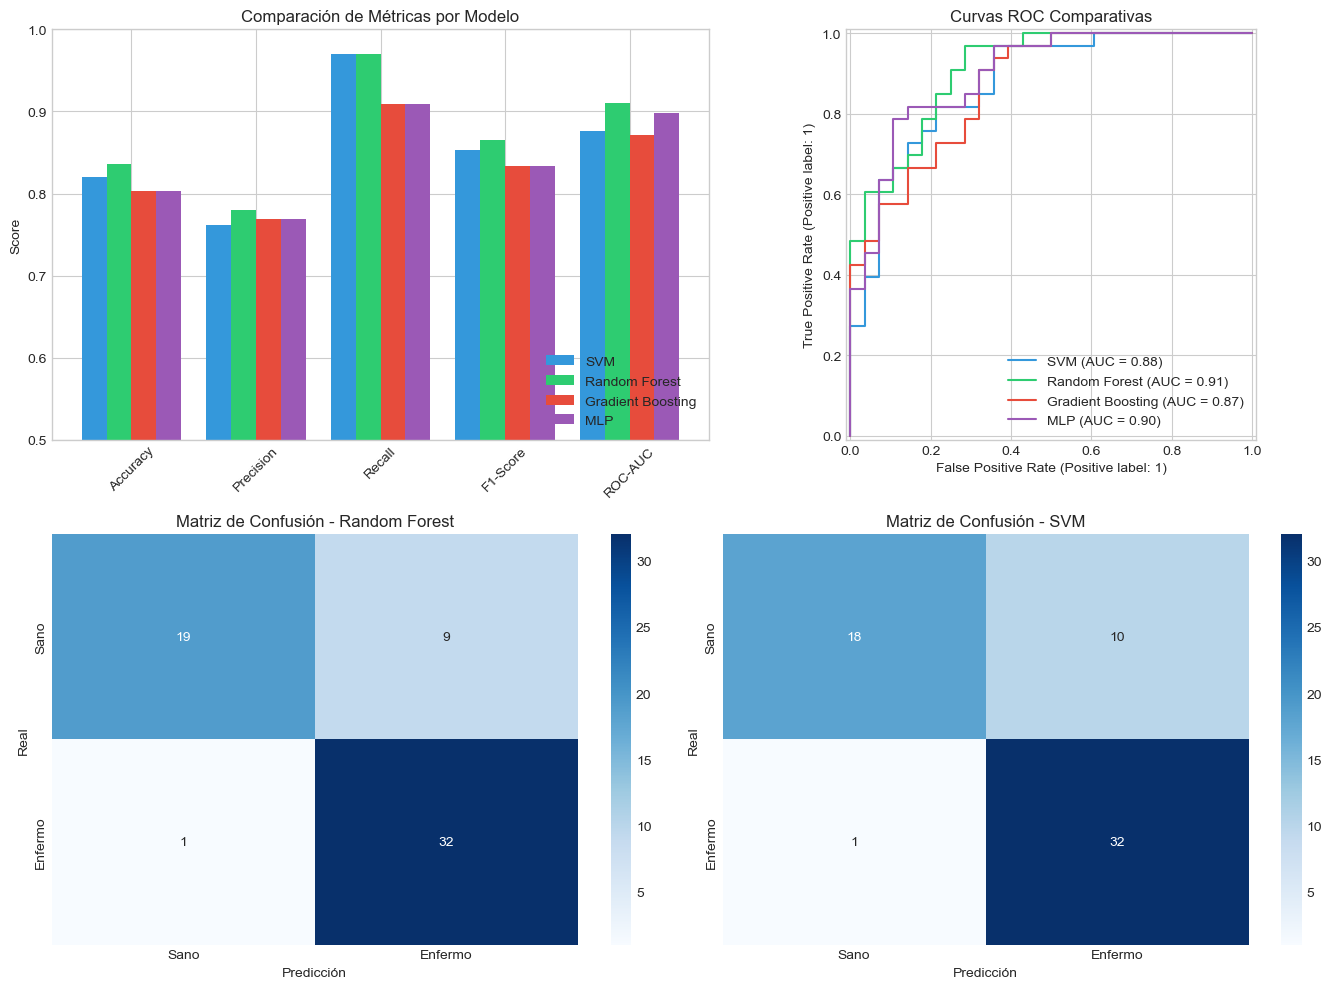

In [50]:
# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colores = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

# Gráfico 1: Comparación de métricas
ax1 = axes[0, 0]
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metricas))
width = 0.2

for i, (idx, row) in enumerate(df_resultados.iterrows()):
    valores = [row[m] for m in metricas]
    ax1.bar(x + i*width, valores, width, label=row['Modelo'], color=colores[i])

ax1.set_ylabel('Score')
ax1.set_title('Comparación de Métricas por Modelo')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(metricas, rotation=45)
ax1.legend(loc='lower right')
ax1.set_ylim(0.5, 1.0)

# Gráfico 2: Curvas ROC
ax2 = axes[0, 1]
for i, resultado in enumerate(resultados_lista):
    RocCurveDisplay.from_predictions(
        y_test, 
        resultado['y_proba'], 
        name=resultado['Modelo'],
        ax=ax2,
        color=colores[i]
    )
ax2.set_title('Curvas ROC Comparativas')
ax2.legend(loc='lower right')

# Gráficos 3-4: Matrices de confusión (mejores 2 modelos)
df_sorted = df_resultados.sort_values('F1-Score', ascending=False)
mejores = df_sorted.head(2)

for i, (idx, row) in enumerate(mejores.iterrows()):
    ax = axes[1, i]
    cm = confusion_matrix(y_test, row['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Sano', 'Enfermo'],
                yticklabels=['Sano', 'Enfermo'])
    ax.set_title(f'Matriz de Confusión - {row["Modelo"]}')
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.savefig('comparacion_modelos_clasificacion.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Análisis de Resultados

In [51]:
# Mejores hiperparámetros encontrados
print("MEJORES HIPERPARÁMETROS ENCONTRADOS")


for nombre, grid in modelos.items():
    print(f"\n{nombre}:")
    for param, valor in grid.best_params_.items():
        param_limpio = param.split('__')[-1]
        print(f"  - {param_limpio}: {valor}")

MEJORES HIPERPARÁMETROS ENCONTRADOS

SVM:
  - C: 0.1
  - gamma: scale
  - kernel: linear

Random Forest:
  - n_estimators: 200
  - min_samples_split: 5
  - min_samples_leaf: 2
  - max_depth: 30

Gradient Boosting:
  - learning_rate: 0.1
  - max_depth: 7
  - n_estimators: 50
  - subsample: 0.8

MLP:
  - learning_rate_init: 0.01
  - hidden_layer_sizes: (50, 50)
  - alpha: 0.001
  - activation: tanh


In [52]:
# Classification Report del mejor modelo
mejor_modelo = df_resultados.loc[df_resultados['F1-Score'].idxmax(), 'Modelo']
mejor_grid = modelos[mejor_modelo]

print(f"CLASSIFICATION REPORT - MEJOR MODELO: {mejor_modelo}")
print(classification_report(
    y_test, 
    mejor_grid.best_estimator_.predict(X_test),
    target_names=['Sano (0)', 'Enfermo (1)']
))

CLASSIFICATION REPORT - MEJOR MODELO: Random Forest
              precision    recall  f1-score   support

    Sano (0)       0.95      0.68      0.79        28
 Enfermo (1)       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61

